## Twitter sentiment analysis with spaCy
Alejandro Granados
Dec 2020

This project consists of the following steps:
* Create spacy pipeline using linear regression model 
* Train the pipeline with data from IMDB reviews
* Download 3k tweets for a specified Twitter user
* Use the pipeline to predict sentiment for each tweet 
* Visualize sentiment as time series using a 7-day moving average 

### Results
* The sentiment classifier trained on IMDB reaches 0.87 accuracy using a Linear Regression model 
* We can classify Tweets using this spacy pipeline 



# Setting up the spacy pipeline

We are going to build a text classification pipeline using spacy and a Linear Regression classifier. 
We are going then to train the pipeline using the IMDB movie reviews dataset. 
Finally, using the Twitter API, we are going to download data and assign sentiment to individual tweets. 

In [1]:
# Set up spaCy
import spacy
# this English package is the default from the website but does not load as the default instructions
spacy.require_gpu() # if you installed the version compatible with GPU

# Here en_core_web_sm is the model 
# nlp is the main object or "the pipeline"
# When you call nlp on a text, spaCy will tokenize it and then call each component on the Doc, in order. 
# It then returns the processed Doc that you can work with.
model = "en_core_web_sm"
nlp = spacy.load(model)


## Textcat: classification of text using neural networks and IMDB data

Our pipeline will consist of a tokenizer, a normalization step and a classifier. 

* First we will define some custom function as to how we want to pre-process the data 
* Then we can put all of these together into a spacy pipeline

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline


In [3]:
%%time

import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.model_selection import train_test_split


punctuations = string.punctuation

# It then returns the processed Doc that you can work with.
model = "en_core_web_sm"
nlp = spacy.load(model)

stop_words = spacy.lang.en.stop_words.STOP_WORDS

# our own custom tokenizer 
# we provide the tokenizer method for scikit-learn
# Remove stop words and PRON
def spacy_tokenizer(sentence):    
    mytokens = nlp(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    return mytokens

# We create a class with a trasnform method
# the transform method will call our clean_text function 

#Here, we will create a custom predictors class wich inherits the 
# TransformerMixin class. This class overrides the transform, fit and 
# get_parrams methods. We’ll also create a clean_text() function that 
# removes spaces and converts text into lowercase.

# Mixins are a sort of class that is used to "mix in" extra properties 
# and methods into a class. This allows you to create classes in a 
# compositional style.
class predictors(TransformerMixin):
    def transform(self,X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y = None, **fit_params):
        return self
    def get_params(self, deep = True):
        return {}
    
def clean_text(text):
    return text.strip().lower()

Wall time: 397 ms


### Using spacy to understand language relationships

In [48]:
from spacy import displacy
doc = nlp("Hi my name is Alejandro, I am a Data Scientist")
t = doc[0]

displacy.render(doc)

In [55]:
# We can ask spacy to explain what this relationships mean 
spacy.explain("nsubj")

'nominal subject'

## Training data

* Option1: Amazon (Alexa) reviews (biased towards positive reviews)
* Option2: IMDB (reviews)
* Option3: 160k tweets with no emoticons from product reviews 

We are going to use the IMDB dataset first 

* Dataset from IMDB with comprises positive and negative reviews. This data is public. 
* We can train our spaCy pipeline with this data to predict the sentiment of someones' Tweets


In [4]:

# Dataset 
#df_amazon = pd.read_csv ("datasets/amazon_alexa.tsv", sep="\t")
df_amazon = pd.read_csv('datasets/imdb_train_25k_binary.csv', sep ='\t\t', engine = 'python')
#df_amazon.feedback.value_counts()

# Split Train / Test 
# For alexa 
#X = df_amazon['verified_reviews'] # the actual data 
# For IMDB
X = df_amazon['text_processed']
# Here are our supervised annotations 
#ylabels = df_amazon['feedback'] # positive or negative: given by the users 

#For IMDB
ylabels = df_amazon['score']


# Generate train/test splits 
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size = 0.3)

### The classification pipeline
* A tokenizer (prepares the doc and cleans stop words, etc)
* Vectorizer: transform words into vectors for the classifier (TF/IDF)
* A classifier: Here we use logistic regression but other sklearn models would also work 

In [42]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC



# Initialize our functions
# ngram_range: how many words to consider at once? Default 1 but it can do pairs for correlations 
# Returns the number of times a word occurs in a corpus 
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

# scikit-learn TfidVectorizer:
# A Term frequency - inverse document freq matrix 
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

# Also look at this pipeline using SVM 
# https://towardsdatascience.com/machine-learning-for-text-classification-using-spacy-in-python-b276b4051a49

# We are using log regression here, but we can also try other clf methods
classifier = LogisticRegression() 
#classifier = LinearSVC()

# Then, we’ll create a pipeline with three components: a cleaner, a vectorizer, and a classifier. 
# The cleaner uses our predictors class object to clean and preprocess the text. The vectorizer 
# uses countvector objects to create the bag of words matrix for our text. 
# The classifier is an object that performs the logistic regression to classify the sentiments.

pipe = Pipeline( [('cleaner', predictors()),  # transform clean
                   ('vectorizer', bow_vector), # transform to matrix frequency 
                   ('classifier', classifier)]) # Logistic regression 



pipe.fit(X_train, y_train)

Wall time: 8min 11s


C:\Users\bacte\anaconda3\envs\twitter\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('cleaner', <__main__.predictors object at 0x0000016CFA3F9970>),
                ('vectorizer',
                 CountVectorizer(tokenizer=<function spacy_tokenizer at 0x0000016CCFCB2D30>)),
                ('classifier', LogisticRegression())])

In [43]:
%%time
# Predict the test dataset 
from sklearn import metrics

predicted = pipe.predict(X_test)

Wall time: 3min 29s


In [30]:
# Look at individual predictions 
i = 10
X_test.values[i],predicted[i], y_test.values[i]

("Being a fan of cheesy horror movies, I saw this in my video shop and thought I would give it a try. Now that I've seen it I wish it upon no living soul on the planet. I get my movie rentals for free, and I feel that I didn't get my moneys worth. I've seen some bad cheesy horror movies in my time, hell I'm a fan of them, but this was just an insult.",
 0,
 0)

## Accuracy 
The Logistic regression model already acomplishes ~0.87 accuracy and ~0.87 precision on the IMDB dataset which is pretty good to start with. 
We can now get some twitter data and start classifying!

In [44]:
# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.8696
Logistic Regression Precision: 0.8686842105263158
Logistic Regression Recall: 0.8732804232804233


# Twitter sentiment 
Now that we have a good sentiment classifier we can proceed to download Tweets and assign them sentiment predictions with out spaCy pipeline. 

## Get data from Twitter 
We are uisng tweepy, we need to setup our account to get access keys.

Once we have the keys we can run the following code.
For security purposes I added my keys on a separte config.py file that I can just import. 

In [87]:
%%time
import datetime
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 
import pandas as pd

# Keep you keys on a separate file 
import config 

consumer_key = config.consumer_key
consumer_secret = config.consumer_secret 

# Log in Twitter API 
auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

tweets = []
sentiments = []

for tweet in tweepy.Cursor(api.user_timeline, screen_name='@jimcramer' ).items():
    tweets.append(tweet)
    
# 100 tweets almost immediate     
# 1000 tweets in 10 seconds 
# 3k tweets in 30 seconds (default when no )
len(tweets)

Wall time: 41.6 s


3224

In [56]:
%%time
# Extract the text from the list of tweets : 
texts = [tweet.text for tweet in tweets]
# Here we use the classifier from spaCy 
predicted = pipe.predict(pd.Series(texts))

Wall time: 15.1 s


In [94]:
# Analyze only tweets in the given date range using Text Blob 
startDate = datetime.datetime(2014, 6, 1, 0, 0, 0)
endDate =   datetime.datetime(2021, 1, 31, 0, 0, 0) # last day of 2020
def get_tweet_sentiment(tweet): 

    clean_tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", tweet).split())
    # create TextBlob object of passed tweet text 
    analysis = TextBlob(clean_tweet) 
    return(analysis.sentiment.polarity)

parsed_tweets = []
sentiments = []
dates  = []
tweet_list = []
for tweet in tweets:
    if tweet.created_at < endDate and tweet.created_at > startDate: # only if they were created during the data range 
        parsed_tweets.append(tweet)
        sentiments.append( get_tweet_sentiment(tweet.text))
        dates.append(tweet.created_at.strftime("%m/%d/%Y"))
        tweet_list.append(tweet.text)


# Let's run the spacy pipeline with the subset of tweets that fell within the range
texts = [tweet.text for tweet in parsed_tweets]
spacy_sentiment = pipe.predict(pd.Series(texts))

        
sentiment_ts = pd.DataFrame({'Date': dates, 'textblob': sentiments, 
                             'spacy': spacy_sentiment, 'tweet':tweet_list})

sentiment_ts['Date'] =pd.to_datetime(sentiment_ts.Date)
sentiment_ts.sort_values('Date') # This now sorts in date order 
sentiment_daily = sentiment_ts.groupby('Date').mean() # we take the average daily sentiment 

# 7 day window average 
sentiment_daily['7day_textblob'] = sentiment_daily.textblob.rolling(7).mean().shift(-3)
sentiment_daily['7day_spacy'] = sentiment_daily.spacy.rolling(7).mean().shift(-3)

sentiment_daily.head()

,textblob,spacy,7day_textblob,7day_spacy
Date,,,,
2020-10-21,0.162432,0.750000,NaN,NaN
2020-10-22,0.231432,0.595238,NaN,NaN
2020-10-23,0.083780,0.631579,NaN,NaN
2020-10-24,0.294683,0.733333,0.134535,0.654697
2020-10-25,0.021993,0.727273,0.114850,0.633722


In [96]:
sentiment_ts

,Date,textblob,spacy,tweet
0,2021-01-29,-0.050,1,We don't know what price the shorts closed out...
1,2021-01-29,0.050,1,We need to have the government enforce the cap...
2,2021-01-29,0.000,0,It is a shame what i am seeing here. I don't m...
3,2021-01-29,0.275,1,I am willing to grant that GameStop is worth t...
4,2021-01-29,-0.400,1,I have NO skin in the game. I do not play for ...
...,...,...,...,...
2970,2020-10-21,0.000,1,About ten years ago. Value people can bet on i...
2971,2020-10-21,-0.200,0,How about Stark Industries leaving the defense...
2972,2020-10-21,0.450,1,Fabulous.. they have never mattered more https...
2973,2020-10-21,0.000,1,We are all wiser for our children's advice. My...


(92, 4)

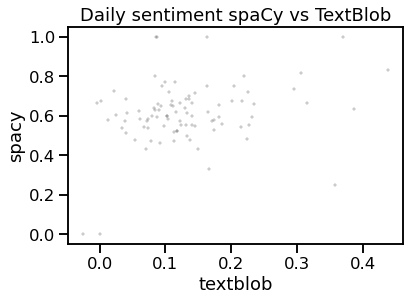

In [98]:
import seaborn as sns
sns.scatterplot(data = sentiment_daily, x = 'textblob', y = 'spacy',
                s=10, color=".2", marker="+").set_title("Daily sentiment spaCy vs TextBlob")
sentiment_daily.shape

Text(0.5, 1.0, 'spaCy vs Textblob regression')

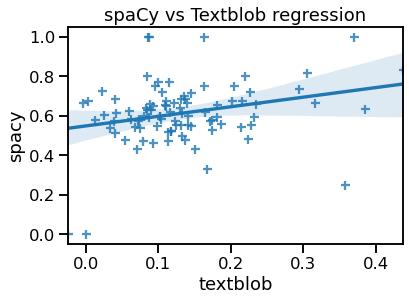

In [101]:
sns.regplot(data = sentiment_daily, x ='textblob', y ='spacy', 
            marker = "+").set_title("spaCy vs Textblob regression")

Text(0.5, 1.0, 'spaCy vs Textblob 7-day MA')

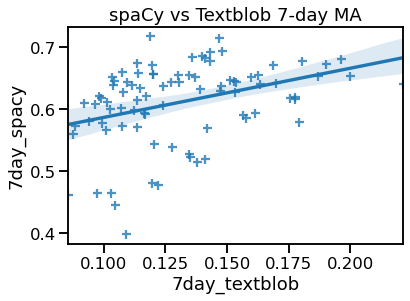

In [103]:
# Let's compare the moving averages 
# this should give us a better correlation since we are removing some noise 

sns.regplot(data = sentiment_daily, x ='7day_textblob', 
            y ='7day_spacy', marker ="+" ).set_title("spaCy vs Textblob 7-day MA")

## Plot sentiment as time-series


Text(0.5, 1.0, 'Average sentiment (7 day MA)')

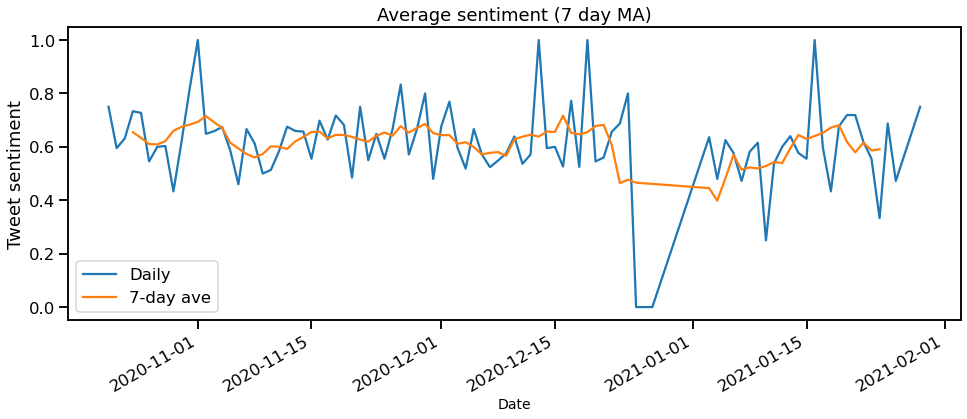

In [104]:
import matplotlib.dates as mdates 
import matplotlib.pyplot as plt 

sentiment_daily.index = pd.to_datetime(sentiment_daily.index)

sns.set_context("talk")

fig, ax = plt.subplots(figsize=(16, 6))

#plt.figure(figsize=(16, 6))

sns.lineplot(data = sentiment_daily, x = 'Date', y='spacy', label ='Daily', ci = None)

sns.lineplot(data =sentiment_daily, x = 'Date', y ='7day_spacy', label = '7-day ave',
            ci = None)

fig.autofmt_xdate() 

plt.xlabel('Date', size = 14)
plt.ylabel('Tweet sentiment')
plt.title('Average sentiment (7 day MA)')


## Additional references 

* https://realpython.com/sentiment-analysis-python/#using-natural-language-processing-to-preprocess-and-clean-text-data